### LIBRARY IMPORTS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter

from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

from googletrans import Translator
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import torch


In [2]:
df = pd.read_excel("./HappinessShuffled.xlsx")

In [3]:
df.isna().sum()

Division                       1
mood_name                      1
reason                         1
Entry_Date                     1
Comments                  199156
Anonymous                      2
Gender                         2
PositionClassification         2
MaritalStatus                  2
HireDate                       2
EducationQualification         2
Discipline                  8748
BloodGroup                     2
Religion                       2
Nationality                    2
EmploymentGroup                2
Location                       2
SeparationDate            205052
SeparationReason          205052
HousingStatus               3270
dtype: int64

In [5]:
test_df = df[df['Comments'].notna()]
test_df.describe()

,Entry_Date,Anonymous,HireDate,SeparationDate
count,7599,7598.000000,7598,217
mean,2021-07-15 10:26:43.383219968,0.187681,2010-02-09 01:10:30.165833216,2022-11-20 00:33:10.783410176
min,2020-12-14 14:00:53.387000,0.000000,1995-07-29 00:00:00,2022-10-27 00:00:00
25%,2021-03-04 06:52:32.120000,0.000000,2001-02-13 00:00:00,2022-11-13 00:00:00
50%,2021-05-30 12:19:09.216999936,0.000000,2013-01-15 00:00:00,2022-11-13 00:00:00
75%,2021-09-08 12:39:51.236499968,0.000000,2016-05-22 00:00:00,2022-11-23 00:00:00
max,2022-09-29 16:02:41.123000,1.000000,2022-01-01 00:00:00,2022-12-12 00:00:00
std,NaN,0.390483,NaN,NaN


In [4]:
df.describe()

,Entry_Date,Anonymous,HireDate,SeparationDate
count,206754,206753.000000,206753,1703
mean,2021-09-09 04:05:36.476441600,0.129231,2012-01-11 08:09:10.082465536,2022-10-29 04:41:34.421608960
min,2020-12-14 12:11:59.657000,0.000000,1990-09-12 00:00:00,2022-09-30 00:00:00
25%,2021-03-23 06:50:04.836999936,0.000000,2008-05-11 00:00:00,2022-10-31 00:00:00
50%,2021-06-29 07:12:31.312999936,0.000000,2013-06-10 00:00:00,2022-10-31 00:00:00
75%,2022-04-20 11:25:23.220000,0.000000,2016-03-02 00:00:00,2022-10-31 00:00:00
max,2022-09-30 15:07:12.707000,1.000000,2022-01-01 00:00:00,2022-12-31 00:00:00
std,NaN,0.335457,NaN,NaN


### DEALING WITH MISSING VALUES

In [5]:
placeholder_date = pd.Timestamp('2022-01-01')


# Fill missing date columns with placeholder date
date_columns = df.select_dtypes(include=[np.datetime64]).columns
for col in date_columns:
    df[col].fillna(placeholder_date, inplace=True)

# Fill missing string columns with blank string
string_columns = df.select_dtypes(include=[object]).columns
for col in string_columns:
    df[col].fillna(' ', inplace=True)

# For completeness, fill missing values in other types of columns (e.g., numeric) with a chosen placeholder (e.g., 0 or a specific value)
numeric_columns = df.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    df[col].fillna(0, inplace=True)

In [6]:
df['Comments'].unique()

array([' ', 'ok', 'supportive', ...,
       'Stranded in India due to flight restrictions by UAE Government.',
       'Stranded in India due to flight restriction by UAE Government. First available flight is on 01st August 2021.',
       'Stranded in India due to flight restrictions by UAE Government. Awaiting to fly back to Abu Dhabi.'],
      dtype=object)

In [7]:
df.isna().sum()

Division                  0
mood_name                 0
reason                    0
Entry_Date                0
Comments                  0
Anonymous                 0
Gender                    0
PositionClassification    0
MaritalStatus             0
HireDate                  0
EducationQualification    0
Discipline                0
BloodGroup                0
Religion                  0
Nationality               0
EmploymentGroup           0
Location                  0
SeparationDate            0
SeparationReason          0
HousingStatus             0
dtype: int64

### EXPLORATORY DATA ANALYSIS

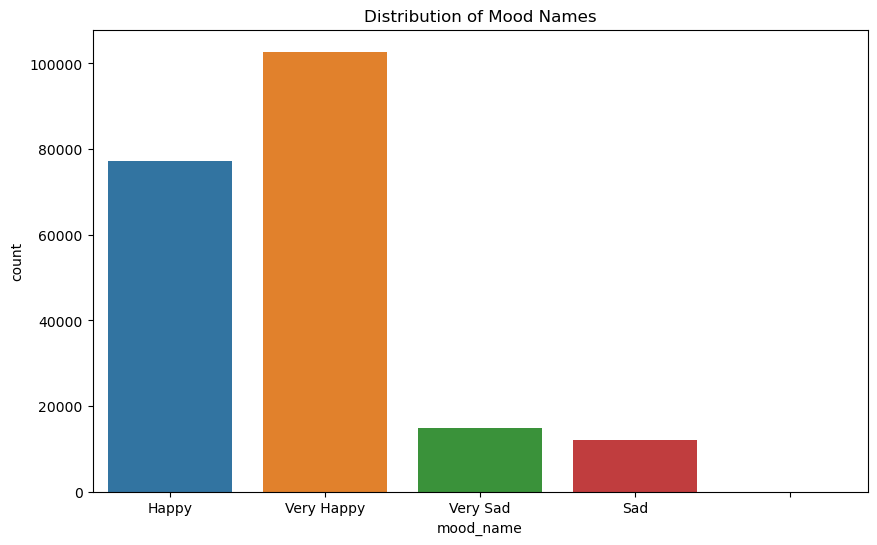

In [8]:
# Distribution of `mood_name`
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='mood_name')
plt.title('Distribution of Mood Names')
plt.show()

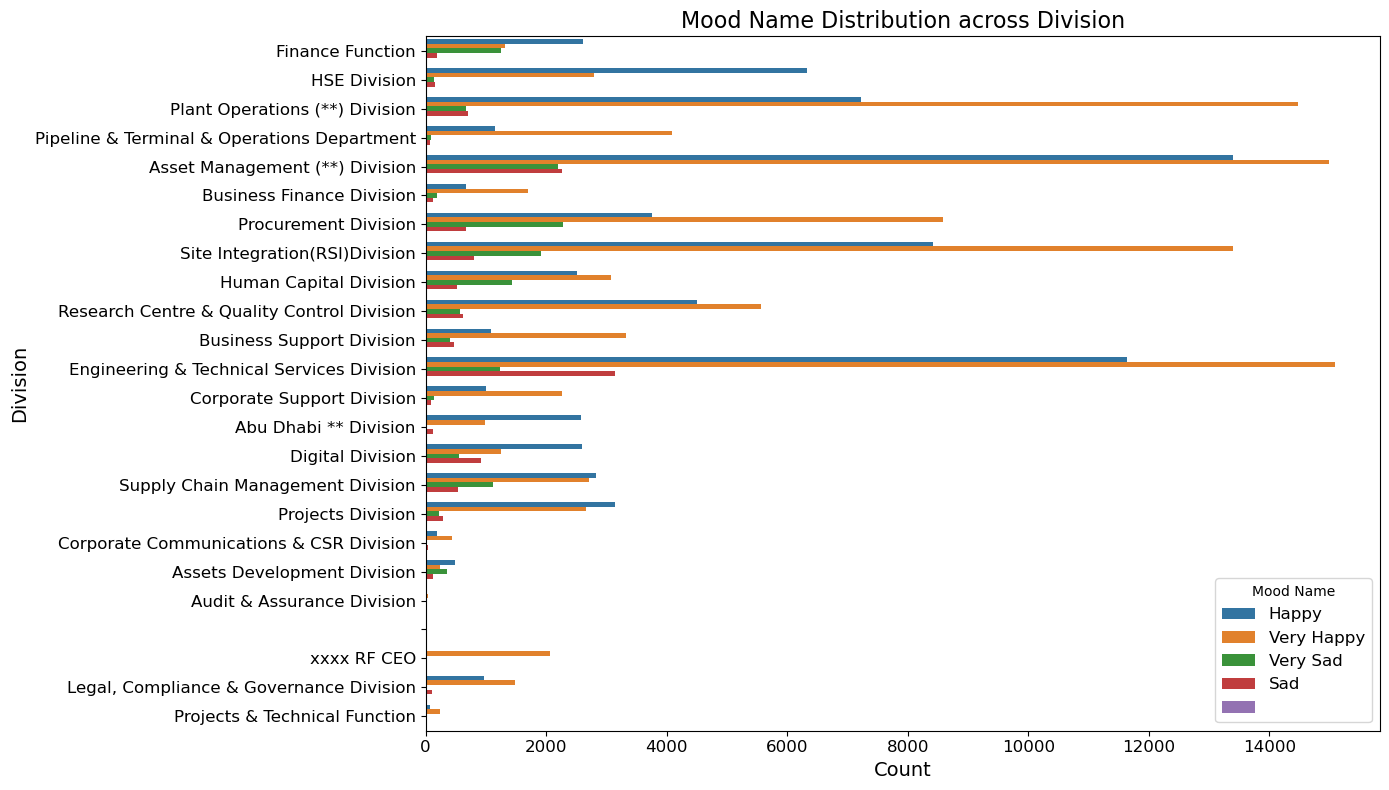

In [9]:
plt.figure(figsize=(14, 8))
sns.countplot(data=df, y='Division', hue='mood_name')
plt.title('Mood Name Distribution across Division', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Division', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Mood Name', fontsize=12)
plt.tight_layout()
plt.show()

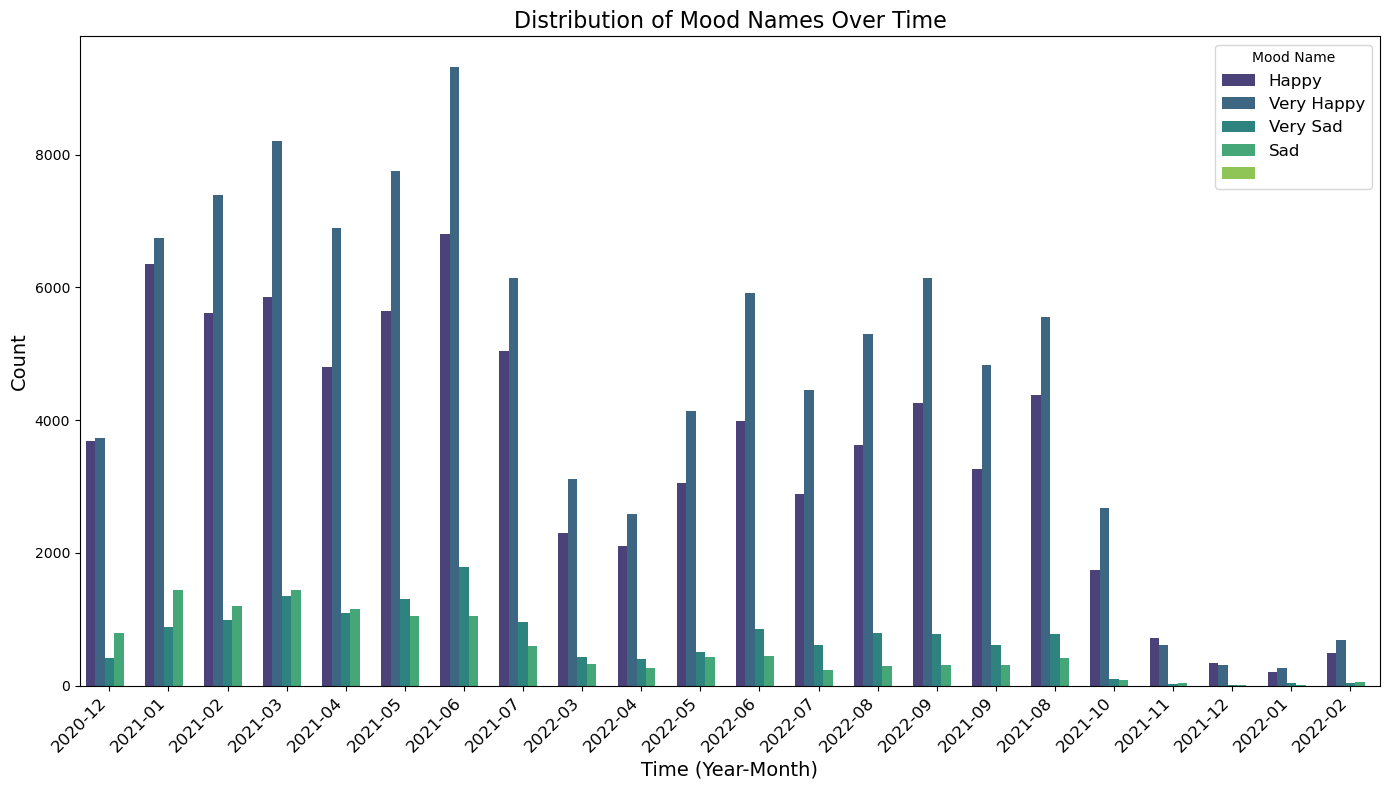

In [10]:
# Extract year and month for analysis
df['YearMonth'] = df['Entry_Date'].dt.to_period('M')

# Plot the distribution of mood_name over time
plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='YearMonth', hue='mood_name', palette='viridis')
plt.title('Distribution of Mood Names Over Time', fontsize=16)
plt.xlabel('Time (Year-Month)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  
plt.legend(title='Mood Name', fontsize=12)
plt.tight_layout()  
plt.show()

### SENTIMENT ANALYSIS TECHNIQUES - MACHINE LEARNING

In [11]:
categorical_columns = ['Division', 'Gender', 'MaritalStatus', 'EmploymentGroup']

# Create a copy of the dataframe to avoid modifying the original data
df_encoded = df.copy()

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' to avoid multicollinearity

# Encode categorical columns
encoded_columns = encoder.fit_transform(df_encoded[categorical_columns])

# Get feature names for the encoded columns
# This is done by retrieving categories from the encoder and constructing names
encoded_column_names = []
for i, col in enumerate(categorical_columns):
    categories = encoder.categories_[i]
    for category in categories[1:]:  # start from index 1 to drop the first category
        encoded_column_names.append(f"{col}_{category}")

# Replace original categorical columns with encoded columns in the dataframe
df_encoded.drop(categorical_columns, axis=1, inplace=True)
df_encoded[encoded_column_names] = encoded_columns

# Display the encoded dataframe
df_encoded.head()


/home/tito/anaconda3/envs/data_engineering/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,mood_name,reason,Entry_Date,Comments,Anonymous,PositionClassification,HireDate,EducationQualification,Discipline,BloodGroup,...,Gender_Female,Gender_Male,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,EmploymentGroup_Agency Contract,EmploymentGroup_Direct Hire,EmploymentGroup_ISH,EmploymentGroup_Special Contracts
0,Happy,Work-Life Balance,2020-12-15 09:08:42.273,,0.0,Individual Contributor,2012-02-19,Bachelor,Accounting,O+,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,Happy,Work-Life Balance,2020-12-16 12:26:29.983,,0.0,Individual Contributor,2012-02-19,Bachelor,Accounting,O+,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Happy,Work-Life Balance,2020-12-17 09:06:48.660,,0.0,Individual Contributor,2012-02-19,Bachelor,Accounting,O+,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Happy,Work-Life Balance,2020-12-20 10:11:27.503,,0.0,Individual Contributor,2012-02-19,Bachelor,Accounting,O+,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Happy,Work-Life Balance,2020-12-21 09:09:09.440,,0.0,Individual Contributor,2012-02-19,Bachelor,Accounting,O+,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
df['reason']

0                  Work-Life Balance 
1                  Work-Life Balance 
2                  Work-Life Balance 
3                  Work-Life Balance 
4                  Work-Life Balance 
                     ...             
206750    Career Development & Growth
206751    Career Development & Growth
206752    Career Development & Growth
206753    Career Development & Growth
206754    Career Development & Growth
Name: reason, Length: 206755, dtype: object

#### Data Preprocessing

In [13]:
# Ensure you have the necessary NLTK data files
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Sample dataframe structure

# Define a function for text preprocessing
def preprocess_text(text):
    # Convert to string
    text = str(text)
    # Lowercase the text
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d', '', text)
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join the words back into a single string
    processed_text = ' '.join(words)
    return processed_text

# Filter out records with empty string comments
df_filtered = df[df['Comments'].str.strip() != '']

# Apply the preprocessing function to the "comments" and "reasons" columns
df_filtered['processed_comments'] = df_filtered['Comments'].apply(preprocess_text)
df_filtered['processed_reasons'] = df_filtered['reason'].fillna('').apply(preprocess_text)

# Split the dataset into training and testing sets if needed
X = df_filtered[['processed_comments', 'processed_reasons']]
y = df_filtered['mood_name']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
/tmp/ipykernel_46268/170504896.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['processed_comments'] = df_filtered['Comments'].apply(preprocess_text)
/tmp/ipykernel_46268/170504896.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [14]:
df_filtered[['Comments', 'processed_comments', 'reason', 'processed_reasons']]


,Comments,processed_comments,reason,processed_reasons
2259,ok,ok,Line Manager,line manager
2266,supportive,supportive,Career Development & Growth,career development growth
2267,supportive,supportive,Line Manager,line manager
2288,Always straight forward and supportive,always straight forward supportive,Career Development & Growth,career development growth
2289,Always straight forward and supportive,always straight forward supportive,Work-Life Balance,work life balance
...,...,...,...,...
206251,Stranded in India due to flight restriction by...,stranded india due flight restriction uae gove...,Work-Life Balance,work life balance
206252,Stranded in India due to flight restrictions b...,stranded india due flight restriction uae gove...,Engagement,engagement
206253,Stranded in India due to flight restrictions b...,stranded india due flight restriction uae gove...,Work-Life Balance,work life balance
206254,Stranded in India due to flight restrictions b...,stranded india due flight restriction uae gove...,Engagement,engagement


In [15]:
df['Comments'].unique()

array([' ', 'ok', 'supportive', ...,
       'Stranded in India due to flight restrictions by UAE Government.',
       'Stranded in India due to flight restriction by UAE Government. First available flight is on 01st August 2021.',
       'Stranded in India due to flight restrictions by UAE Government. Awaiting to fly back to Abu Dhabi.'],
      dtype=object)

In [16]:
# Combine processed text columns into a single feature
df_filtered['combined_text'] = df_filtered['processed_comments'] + ' ' + df_filtered['processed_reasons']

# Define features and target variable
X = df_filtered['combined_text']
y = df_filtered['mood_name']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transform text data to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

/tmp/ipykernel_46268/1647046420.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['combined_text'] = df_filtered['processed_comments'] + ' ' + df_filtered['processed_reasons']


#### Model Initialization and Training

In [17]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear'),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_tfidf, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_tfidf)
    
    # Evaluate the model
    print(f'--- {model_name} ---')
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Classification Report:')
    print(classification_report(y_test, y_pred))


--- Logistic Regression ---
Accuracy: 0.8592105263157894
Classification Report:
              precision    recall  f1-score   support

       Happy       0.81      0.67      0.73       203
         Sad       0.81      0.53      0.64       163
  Very Happy       0.87      0.95      0.91       638
    Very Sad       0.87      0.92      0.89       516

    accuracy                           0.86      1520
   macro avg       0.84      0.77      0.79      1520
weighted avg       0.86      0.86      0.85      1520

--- Naive Bayes ---
Accuracy: 0.8111842105263158
Classification Report:
              precision    recall  f1-score   support

       Happy       0.84      0.51      0.63       203
         Sad       0.83      0.31      0.45       163
  Very Happy       0.80      0.97      0.88       638
    Very Sad       0.81      0.90      0.85       516

    accuracy                           0.81      1520
   macro avg       0.82      0.67      0.70      1520
weighted avg       0.81      0.81

In [18]:
# Initialize and train a Logistic Regression model
sentiment_classifier = LogisticRegression(max_iter=1000)
sentiment_classifier.fit(X_train_tfidf, y_train)

# Example function to predict sentiment based on input text
def predict_sentiment(text):
    processed_text = preprocess_text(text)
    text_tfidf = vectorizer.transform([processed_text])
    sentiment_label = sentiment_classifier.predict(text_tfidf)[0]
    return sentiment_label

# Example usage
text_to_classify = "Its a working progress"
predicted_sentiment = predict_sentiment(text_to_classify)
print(f'Predicted sentiment: {predicted_sentiment}')


Predicted sentiment: Sad


In [19]:
df.columns

Index(['Division', 'mood_name', 'reason', 'Entry_Date', 'Comments',
       'Anonymous', 'Gender', 'PositionClassification', 'MaritalStatus',
       'HireDate', 'EducationQualification', 'Discipline', 'BloodGroup',
       'Religion', 'Nationality', 'EmploymentGroup', 'Location',
       'SeparationDate', 'SeparationReason', 'HousingStatus', 'YearMonth'],
      dtype='object')

In [20]:
nltk.download('vader_lexicon')


# Initialize sentiment analyzer (Vader in this case)
sid = SentimentIntensityAnalyzer()

# Function to assign sentiment label based on compound score
def get_sentiment_label(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Calculate sentiment scores for each processed comment
sentiments = []
for comment in df_filtered['processed_comments']:
    scores = sid.polarity_scores(comment)
    sentiment = get_sentiment_label(scores['compound'])
    sentiments.append(sentiment)

# Add sentiment labels to DataFrame
df_filtered['Sentiment'] = sentiments


[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
/tmp/ipykernel_46268/3587362757.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Sentiment'] = sentiments


In [21]:
df.columns

Index(['Division', 'mood_name', 'reason', 'Entry_Date', 'Comments',
       'Anonymous', 'Gender', 'PositionClassification', 'MaritalStatus',
       'HireDate', 'EducationQualification', 'Discipline', 'BloodGroup',
       'Religion', 'Nationality', 'EmploymentGroup', 'Location',
       'SeparationDate', 'SeparationReason', 'HousingStatus', 'YearMonth'],
      dtype='object')

In [22]:
columns = ['Discipline', 'BloodGroup', 'Religion','Nationality', 'Location' ]


for col in columns:
    sentiment_scores = df_filtered.groupby(col)['Sentiment'].value_counts(normalize=True).unstack().fillna(0)
    print(f"Sentiment Scores by {col}:")
    print(sentiment_scores)
    print("======================================================================")



Sentiment Scores by Discipline:
Sentiment                 negative   neutral  positive
Discipline                                            
                          0.122222  0.400000  0.477778
ATI                       1.000000  0.000000  0.000000
Accounting                0.623810  0.207143  0.169048
Accounting/Auditing       0.000000  1.000000  0.000000
Administration            0.093750  0.406250  0.500000
...                            ...       ...       ...
Strategic Management      1.000000  0.000000  0.000000
Supply Chain Management   0.000000  1.000000  0.000000
Technical                 0.000000  0.111111  0.888889
Training And Development  0.028571  0.428571  0.542857
Welding                   0.000000  1.000000  0.000000

[138 rows x 3 columns]
Sentiment Scores by BloodGroup:
Sentiment   negative   neutral  positive
BloodGroup                              
            0.000000  0.000000  1.000000
A+          0.096033  0.403619  0.500348
A-          0.407895  0.092105  0

#### Sentiment-bearing words and Visualization

Sentiment-bearing words identify words that frequently appear in the comments and reasons that affect the mood name. They reflect the tone of the comments.

In [23]:
# Identify sentiment-bearing words
word_counts = Counter()
for comment in df_filtered[df_filtered['Sentiment'].isin(['positive', 'negative'])]['processed_comments']:
    words = comment.split()
    word_counts.update(words)

# Print top 10 sentiment-bearing words
print("Top 10 Sentiment-Bearing Words:")
print(word_counts.most_common(10))


Top 10 Sentiment-Bearing Words:
[('pc', 1428), ('good', 1403), ('work', 1017), ('year', 891), ('division', 773), ('job', 717), ('meeting', 699), ('since', 675), ('manager', 649), ('team', 634)]


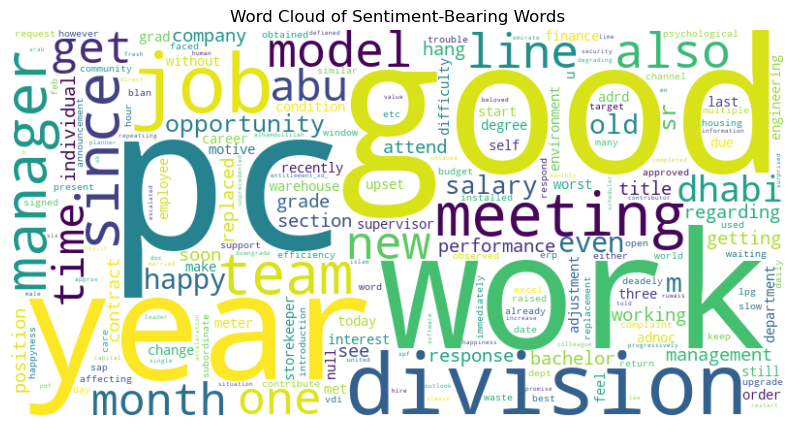

In [24]:
# Generate and display word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(word_counts))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Sentiment-Bearing Words')
plt.show()

### DEEP LEARNING FOR SENTIMENT ANALYSIS

In [2]:
df = pd.read_excel("./HappinessShuffled.xlsx")  


In [3]:
# Ensure that the necessary columns are present
df = df[df["Comments"].notna()]

df = df[['Comments', 'reason', 'mood_name']]

# Combine Comments and Reasons into a single column
df['Comments'] = df['Comments'].astype(str)  # Ensure Comments are strings
df['reason'] = df['reason'].astype(str)  # Ensure reason are strings
df['text'] = df['Comments'] + ' ' + df['reason']

# Encode mood_name as labels
label_mapping = {label: idx for idx, label in enumerate(df['mood_name'].unique())}
df['labels'] = df['mood_name'].map(label_mapping)

# Split dataset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(), df['labels'].tolist(), test_size=0.2, random_state=42
)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Convert data to torch tensors
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping))

# Set up training arguments with tweaks
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,  
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=32,  
    warmup_steps=100,  
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100, 
    evaluation_strategy="epoch",
    fp16=True
)

# Define compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(eval_results)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/tito/anaconda3/envs/neurons/lib/python3.12/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 26%|██▋       | 100/380 [35:14<1:36:27, 20.67s/it]

{'loss': 0.9722, 'grad_norm': 6.166436195373535, 'learning_rate': 5e-05, 'epoch': 0.53}


                                                     
 50%|█████     | 190/380 [1:12:08<1:03:15, 19.98s/it]

{'eval_loss': 0.378173828125, 'eval_accuracy': 0.8513157894736842, 'eval_f1': 0.8477481140077439, 'eval_precision': 0.846313383013199, 'eval_recall': 0.8513157894736842, 'eval_runtime': 307.3137, 'eval_samples_per_second': 4.946, 'eval_steps_per_second': 0.156, 'epoch': 1.0}


 53%|█████▎    | 200/380 [1:15:39<1:15:04, 25.03s/it] 

{'loss': 0.5024, 'grad_norm': 7.645971298217773, 'learning_rate': 3.2142857142857144e-05, 'epoch': 1.05}


 79%|███████▉  | 300/380 [1:49:41<27:26, 20.58s/it]  

{'loss': 0.3172, 'grad_norm': 5.650529384613037, 'learning_rate': 1.4285714285714285e-05, 'epoch': 1.58}


                                                   
100%|██████████| 380/380 [2:22:29<00:00, 22.50s/it]


{'eval_loss': 0.3074378967285156, 'eval_accuracy': 0.8881578947368421, 'eval_f1': 0.8888450035181287, 'eval_precision': 0.8900375699026389, 'eval_recall': 0.8881578947368421, 'eval_runtime': 311.5173, 'eval_samples_per_second': 4.879, 'eval_steps_per_second': 0.154, 'epoch': 2.0}
{'train_runtime': 8549.4781, 'train_samples_per_second': 1.422, 'train_steps_per_second': 0.044, 'train_loss': 0.5296906973186292, 'epoch': 2.0}


100%|██████████| 48/48 [05:11<00:00,  6.50s/it]

{'eval_loss': 0.3074378967285156, 'eval_accuracy': 0.8881578947368421, 'eval_f1': 0.8888450035181287, 'eval_precision': 0.8900375699026389, 'eval_recall': 0.8881578947368421, 'eval_runtime': 318.4856, 'eval_samples_per_second': 4.773, 'eval_steps_per_second': 0.151, 'epoch': 2.0}


### DETERMINE POLARITY SCORE

In [ ]:
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to get polarity scores
def get_polarity_scores(text):
    scores = sid.polarity_scores(text)
    return scores['compound']  # Using 'compound' score for overall sentiment polarity

# Apply the polarity scoring function to 'processed_comments' and 'processed_reasons'
df_filtered['comment_polarity'] = df_filtered['processed_comments'].apply(get_polarity_scores)
df_filtered['reason_polarity'] = df_filtered['processed_reasons'].apply(get_polarity_scores)

# Analyze the results
# Display the first few rows of the dataframe to verify
df_filtered[['processed_comments', 'comment_polarity', 'processed_reasons', 'reason_polarity']]

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/tito/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/tmp/ipykernel_12042/3647187460.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['comment_polarity'] = df_filtered['processed_comments'].apply(get_polarity_scores)
/tmp/ipykernel_12042/3647187460.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['reason_polarity'] = df_filtered['processed_reasons'].apply(get_polarity_scores)


,processed_comments,comment_polarity,processed_reasons,reason_polarity
2259,ok,0.2960,line manager,0.0000
2266,supportive,0.2960,career development growth,0.3818
2267,supportive,0.2960,line manager,0.0000
2288,always straight forward supportive,0.4767,career development growth,0.3818
2289,always straight forward supportive,0.4767,work life balance,0.0000
...,...,...,...,...
206251,stranded india due flight restriction uae gove...,-0.2732,work life balance,0.0000
206252,stranded india due flight restriction uae gove...,-0.2732,engagement,0.4588
206253,stranded india due flight restriction uae gove...,-0.2732,work life balance,0.0000
206254,stranded india due flight restriction uae gove...,-0.2732,engagement,0.4588


In [ ]:
df_filtered['processed_comments'].nunique()

1860

In [ ]:
# Top 20 most positive comments
top_20_positive_comments = df_filtered.nlargest(20, 'comment_polarity')[['processed_comments', 'comment_polarity']]
print("Top 20 Most Positive Comments:")
print(top_20_positive_comments)

# Top 20 most negative comments
top_20_negative_comments = df_filtered.nsmallest(20, 'comment_polarity')[['processed_comments', 'comment_polarity']]
print("Top 20 Most Negative Comments:")
print(top_20_negative_comments)



Top 20 Most Positive Comments:
                                       processed_comments  comment_polarity
57966   culture simply shared way something passion ma...            0.9999
84072   good morning sir gautam kumar da emp shift sup...            0.9977
84073   good morning sir gautam kumar da emp shift sup...            0.9977
84074   good morning sir gautam kumar da emp shift sup...            0.9977
84066   since association great organization remained ...            0.9976
84067   since association great organization remained ...            0.9976
84068   since association great organization remained ...            0.9976
84069   since association great organization remained ...            0.9971
84070   since association great organization remained ...            0.9971
84071   since association great organization remained ...            0.9971
116086  last working day take opportunity thanks adnoc...            0.9856
116087  last working day take opportunity thanks adnoc...

In [ ]:
# Top 20 most positive reasons
top_20_positive_reasons = df_filtered.nlargest(20, 'reason_polarity')[['processed_reasons', 'reason_polarity']]
print("Top 20 Most Positive Reasons:")
print(top_20_positive_reasons)

# Top 20 most negative reasons
top_20_negative_reasons = df_filtered.nsmallest(20, 'reason_polarity')[['processed_reasons', 'reason_polarity']]
print("Top 20 Most Negative Reasons:")
print(top_20_negative_reasons)


Top 20 Most Positive Reasons:
     processed_reasons  reason_polarity
2485        engagement           0.4588
2537        engagement           0.4588
3042        engagement           0.4588
3923        engagement           0.4588
5215        engagement           0.4588
8314        engagement           0.4588
8319        engagement           0.4588
8324        engagement           0.4588
8328        engagement           0.4588
8333        engagement           0.4588
8338        engagement           0.4588
8343        engagement           0.4588
8348        engagement           0.4588
8353        engagement           0.4588
8358        engagement           0.4588
8363        engagement           0.4588
8368        engagement           0.4588
8373        engagement           0.4588
8378        engagement           0.4588
9123        engagement           0.4588
Top 20 Most Negative Reasons:
               processed_reasons  reason_polarity
2259                line manager              0.0


### MULTINATIONALITY ANALYSIS 

To perform this analysis, the different languages used will be identified and analyzed accordingly.

In [ ]:
# To ensure consistency in language detection
DetectorFactory.seed = 0

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

# Assuming 'processed_comments' is the column with the comments
df_filtered['comment_language'] = df_filtered['processed_comments'].apply(detect_language)

# Assuming 'processed_reasons' is the column with the reasons
df_filtered['reason_language'] = df_filtered['processed_reasons'].apply(detect_language)

# Display the detected languages and their counts
print("Language distribution in comments:")
print(df_filtered['comment_language'].value_counts())

print("Language distribution in reasons:")
print(df_filtered['reason_language'].value_counts())

/tmp/ipykernel_12042/965538931.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['comment_language'] = df_filtered['processed_comments'].apply(detect_language)


Language distribution in comments:
comment_language
en         3904
so         1483
pl          343
af          224
nl          182
ro          157
et          156
fr          155
it          130
sk          119
unknown     111
da           80
id           80
no           64
fi           63
ca           59
sv           59
es           46
cy           44
sl           26
pt           25
tl           21
sq           14
sw           11
hr           10
hu            9
lv            9
tr            7
cs            5
vi            2
lt            1
Name: count, dtype: int64
Language distribution in reasons:
reason_language
en    4043
nl    1143
da     943
it     760
ro     710
Name: count, dtype: int64


/tmp/ipykernel_12042/965538931.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['reason_language'] = df_filtered['processed_reasons'].apply(detect_language)


Translations and sentiment scores

Adding language columns to our golden columns

In [ ]:
test_df = df_filtered.head(100)
test_df

,Division,mood_name,reason,Entry_Date,Comments,Anonymous,Gender,PositionClassification,MaritalStatus,HireDate,...,HousingStatus,YearMonth,processed_comments,processed_reasons,combined_text,Sentiment,comment_polarity,reason_polarity,comment_language,reason_language
2259,Finance Function,Happy,Line Manager,2021-01-17 08:43:23.463,ok,1.0,Male,Individual Contributor,Married,2019-05-21,...,0-Housing Financial Assistance,2021-01,ok,line manager,ok line manager,positive,0.2960,0.0000,sk,da
2266,Finance Function,Very Happy,Career Development & Growth,2021-02-04 08:43:31.077,supportive,0.0,Male,Individual Contributor,Married,2019-05-21,...,0-Housing Financial Assistance,2021-02,supportive,career development growth,supportive career development growth,positive,0.2960,0.3818,it,en
2267,Finance Function,Very Happy,Line Manager,2021-02-04 08:43:31.077,supportive,0.0,Male,Individual Contributor,Married,2019-05-21,...,0-Housing Financial Assistance,2021-02,supportive,line manager,supportive line manager,positive,0.2960,0.0000,it,da
2288,Finance Function,Happy,Career Development & Growth,2021-03-07 10:26:40.990,Always straight forward and supportive,0.0,Male,Individual Contributor,Married,2019-05-21,...,0-Housing Financial Assistance,2021-03,always straight forward supportive,career development growth,always straight forward supportive career deve...,positive,0.4767,0.3818,en,en
2289,Finance Function,Happy,Work-Life Balance,2021-03-07 10:26:40.990,Always straight forward and supportive,0.0,Male,Individual Contributor,Married,2019-05-21,...,0-Housing Financial Assistance,2021-03,always straight forward supportive,work life balance,always straight forward supportive work life b...,positive,0.4767,0.0000,en,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8340,Plant Operations (**) Division,Very Sad,Career Development & Growth,2021-08-28 00:30:05.167,neglected and not involved in the job,0.0,Male,Individual Contributor,Single,2018-09-23,...,EN-Monthly Housing Entitlement,2021-08,neglected involved job,career development growth,neglected involved job career development growth,negative,-0.5267,0.3818,en,en
8341,Plant Operations (**) Division,Very Sad,Learning & development,2021-08-28 00:30:05.167,neglected and not involved in the job,0.0,Male,Individual Contributor,Single,2018-09-23,...,EN-Monthly Housing Entitlement,2021-08,neglected involved job,learning development,neglected involved job learning development,negative,-0.5267,0.0000,en,en
8342,Plant Operations (**) Division,Very Sad,Line Manager,2021-08-28 00:30:05.167,neglected and not involved in the job,0.0,Male,Individual Contributor,Single,2018-09-23,...,EN-Monthly Housing Entitlement,2021-08,neglected involved job,line manager,neglected involved job line manager,negative,-0.5267,0.0000,en,da
8343,Plant Operations (**) Division,Very Sad,Engagement,2021-09-04 12:14:31.783,"neglected and not involved in the job, finishe...",0.0,Male,Individual Contributor,Single,2018-09-23,...,EN-Monthly Housing Entitlement,2021-09,neglected involved job finished ydp program as...,engagement,neglected involved job finished ydp program as...,negative,-0.5267,0.4588,en,nl


In [ ]:
# Function to detect language
def detect_language(text):
    try:
        return detect(text)
    except Exception as e:
        print(f"Error detecting language: {e}")
        return 'unknown'
    
   #'processed_comments','comment_language', 

# Detect language for comments and reasons
# df_filtered['comment_language'] = df_filtered['processed_comments'].apply(detect_language)
test_df['comment_language'] = test_df['processed_comments'].apply(detect_language)

test_df[ 'comment_language'].unique()

Error detecting language: No features in text.
Error detecting language: No features in text.


/tmp/ipykernel_12042/2808664169.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['comment_language'] = test_df['processed_comments'].apply(detect_language)


array(['sk', 'it', 'en', 'fr', 'af', 'sv', 'cy', 'lv', 'ro', 'hu', 'pl',
       'tl', 'so', 'unknown', 'nl'], dtype=object)

Testing whether the the comments in different languages are actually pure, or its a combination with english

In [ ]:
test_df[test_df['comment_language']=='fr']

,Division,mood_name,reason,Entry_Date,Comments,Anonymous,Gender,PositionClassification,MaritalStatus,HireDate,...,HousingStatus,YearMonth,processed_comments,processed_reasons,combined_text,Sentiment,comment_polarity,reason_polarity,comment_language,reason_language
2405,Finance Function,Sad,Empowerment & Responsibility,2022-03-18 09:27:15.730,Very Less Increment after grade change,0.0,Male,Individual Contributor,Married,2019-05-21,...,0-Housing Financial Assistance,2022-03,le increment grade change,empowerment responsibility,le increment grade change empowerment responsi...,neutral,0.0,0.0000,fr,en
2988,Asset Management (**) Division,Sad,Career Development & Growth,2020-12-28 08:13:45.100,My Job Grade rectification and Salary adjust +...,0.0,Male,Individual Contributor,Single,2018-07-23,...,8-Company Accommodation,2020-12,job grade rectification salary adjust rembours...,career development growth,job grade rectification salary adjust rembours...,neutral,0.0,0.3818,fr,en
2996,Asset Management (**) Division,Sad,Work-Life Balance,2021-01-13 08:33:35.493,Transportation not available,0.0,Male,Individual Contributor,Single,2018-07-23,...,8-Company Accommodation,2021-01,transportation available,work life balance,transportation available work life balance,neutral,0.0,0.0000,fr,en
3042,Asset Management (**) Division,Sad,Engagement,2021-03-16 08:02:43.843,No transportation available,0.0,Male,Individual Contributor,Single,2018-07-23,...,8-Company Accommodation,2021-03,transportation available,engagement,transportation available engagement,neutral,0.0,0.4588,fr,nl
3043,Asset Management (**) Division,Sad,Work-Life Balance,2021-03-16 08:02:43.843,No transportation available,0.0,Male,Individual Contributor,Single,2018-07-23,...,8-Company Accommodation,2021-03,transportation available,work life balance,transportation available work life balance,neutral,0.0,0.0000,fr,en
3044,Asset Management (**) Division,Sad,Learning & development,2021-03-16 08:02:43.843,No transportation available,0.0,Male,Individual Contributor,Single,2018-07-23,...,8-Company Accommodation,2021-03,transportation available,learning development,transportation available learning development,neutral,0.0,0.0000,fr,en
3050,Asset Management (**) Division,Sad,Work-Life Balance,2021-03-24 08:32:27.780,Again no transportation available or arrange f...,0.0,Male,Individual Contributor,Single,2018-07-23,...,8-Company Accommodation,2021-03,transportation available arrange pm task,work life balance,transportation available arrange pm task work ...,neutral,0.0,0.0000,fr,en
